In [28]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

np.random.seed(42)



In [29]:
#usedCols = ["Age", "Weight", "Height", "Neck", "Chest", "Abdomen", "Hip", "Thigh", "Knee", "Ankle", "Biceps", "Forearm", "Wrist", "class"]
usedCols = ["Thigh", "Weight", "Abdomen", "Chest", "Hip", "class"]
dataset = pd.read_csv("../dataset/Testdata.csv", usecols=usedCols)

#height = dataset[["Height"]].values
weight = dataset[["Weight"]].values

# Anpassung der Daten "Height" und "Weight" auf das Metrische Masssystem
for index in range(len(weight)):
    #height[index] = height[index] * 2.54
    weight[index] = weight[index] * 0.454

#dataset[["Height"]] = height
dataset[["Weight"]] = weight
dataset


,Weight,Chest,Abdomen,Hip,Thigh,class
0,70.0295,93.1,85.2,94.5,59.0,12.3
1,78.6555,93.6,83.0,98.7,58.7,6.1
2,69.9160,95.8,87.9,99.2,59.6,25.3
3,83.8765,101.8,86.4,101.2,60.1,10.4
4,83.6495,97.3,100.0,101.9,63.2,28.7
...,...,...,...,...,...,...
240,60.9495,89.2,83.6,88.8,49.6,11.0
241,91.2540,108.5,105.0,104.5,59.6,33.6
242,84.7845,111.1,111.5,101.7,60.3,29.3
243,86.6005,108.3,101.3,97.8,56.0,26.0


In [30]:
corr_matrix = dataset.corr(numeric_only=True)
corr_matrix["class"].sort_values(ascending=False)

class      1.000000
Abdomen    0.820663
Chest      0.694344
Hip        0.624515
Weight     0.605888
Thigh      0.534046
Name: class, dtype: float64

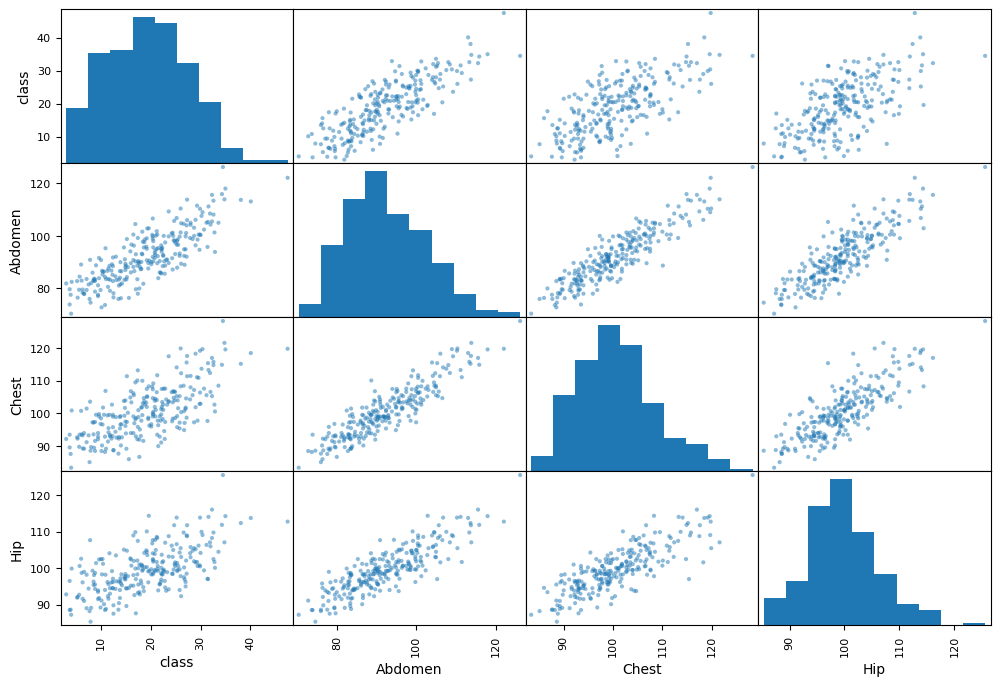

In [31]:
from pandas.plotting import scatter_matrix

attributes = ["class", "Abdomen", "Chest",
              "Hip"]
scatter_matrix(dataset[attributes], figsize=(12, 8))
plt.show()

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Beispiel-Daten
df = pd.DataFrame(dataset)

# Korrelationsmatrix berechnen
corr_matrix = df.corr()

# Heatmap zeichnen
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korrelationsmatrix")
plt.show()


ModuleNotFoundError: No module named 'seaborn'

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Daten vorbereiten
X = dataset[["Thigh", "Weight", "Abdomen", "Chest", "Hip"]]
Y = dataset['class']

# Transformationen definieren
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ["Thigh", "Weight", "Abdomen", "Chest", "Hip"]),
])

# Pipeline erstellen
pipelineLinear = Pipeline([
    ('prep', preprocessor),
    ('model', LinearRegression())
])

pipelineDecisionTree = Pipeline([
    ('prep', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

pipelineForest = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestRegressor (n_estimators=200, max_features=4, random_state=42))
])

# Training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
pipelineLinear.fit(X_train, Y_train)
pipelineDecisionTree.fit(X_train, Y_train)


# Vorhersage
y_predLinear = pipelineLinear.predict(X_train)
y_predDecisionTree = pipelineDecisionTree.predict(X_train)


y_predLinear[:5]


array([22.85711111, 11.92631854, 18.52079432, 17.57011521, 13.5780378 ])

In [ ]:
Y_train[:5]


229    24.8
209    13.6
96     21.2
168    16.9
84      8.3
Name: class, dtype: float64

In [ ]:
Y_train[:5]

229    24.8
209    13.6
96     21.2
168    16.9
84      8.3
Name: class, dtype: float64

In [ ]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(pipelineDecisionTree, X_train, Y_train,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_rmses).describe()

count    10.000000
mean      6.674016
std       1.142511
min       4.698032
25%       6.148676
50%       6.633121
75%       7.296074
max       8.608397
dtype: float64

In [37]:
lin_rmses = -cross_val_score(pipelineLinear, X_train, Y_train,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count    10.000000
mean      4.438687
std       0.610162
min       3.590277
25%       4.105710
50%       4.333090
75%       4.844759
max       5.624536
dtype: float64

In [44]:
forest_rmses = -cross_val_score(pipelineForest, X_train, Y_train,
                                scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count    10.000000
mean      5.049902
std       0.778689
min       3.357295
25%       4.734327
50%       5.336367
75%       5.450764
max       6.074238
dtype: float64

In [38]:
from sklearn.model_selection import GridSearchCV


full_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'random_forest__max_features': [4, 6, 8],  # Optimierung der Featureanzahl für RF
     'random_forest__n_estimators': [50, 100, 200]},  # Anzahl der Bäume im Wald
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, Y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Thigh',
                                                                          'Weight',
                                                                          'Abdomen',
                                                                          'Chest',
                                                                          'Hip'])])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'random_forest__max_features': [4, 6, 8],
                          'random_forest__n_estimators': [50, 100, 200]}],
             scoring='neg_root_mean_squared_error')

In [39]:
grid_search.best_params_

{'random_forest__max_features': 4, 'random_forest__n_estimators': 200}

In [40]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Thigh', 'Weight', 'Abdomen',
                                                   'Chest', 'Hip'])])),
                ('random_forest',
                 RandomForestRegressor(max_features=4, n_estimators=200,
                                       random_state=42))])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

param_grid = [
    {"preprocessing__scaler": ["passthrough", StandardScaler()],
     "model__alpha": [0.01, 0.1, 1, 10, 100]}
]

model = LinearRegression()
grid = GridSearchCV(model, param_grid, cv=5,
                           scoring='r2',
                           return_train_score=True)
grid.fit(X_train, Y_train)

y_pred = grid.predict(X_test)

print("Best estimator across ALL searched params:\n",grid.best_estimator_)
print("Best score across ALL searched params:\n",grid.best_score_)
print("Best parameters across ALL searched params:\n",grid.best_params_)

ValueError: Invalid parameter 'model' for estimator LinearRegression(). Valid parameters are: ['copy_X', 'fit_intercept', 'n_jobs', 'positive'].